In [1]:
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ensure reproducibility
torch.manual_seed(42)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'Number of GPUs available: {torch.cuda.device_count()}')

# Path to the JSON file
json_path = '/kaggle/input/combined-landscape-captions/combined_landscape_captions.json'

# Load JSON data
with open(json_path, 'r') as f:
    data = json.load(f)

# Verify the number of samples
print(f"Total samples: {len(data)}")

# Optional: Inspect a sample
sample_image_path, sample_caption = next(iter(data.items()))
print(f"Sample Image Path: {sample_image_path}")
print(f"Sample Caption: {sample_caption}")


Using device: cuda
Number of GPUs available: 2
Total samples: 14319
Sample Image Path: /kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Training Data/Coast/Coast-Train (1868).jpeg
Sample Caption: palm trees and the skyline of miami at sunset


In [5]:
class LandscapeDataset(Dataset):
    def __init__(self, data, image_transform=None, tokenizer=None, max_length=128):
        """
        Args:
            data (dict): Dictionary with image paths as keys and captions as values.
            image_transform (callable, optional): Optional transform to be applied on an image.
            tokenizer (transformers.PreTrainedTokenizer, optional): Tokenizer for captions.
            max_length (int): Maximum length for tokenized captions.
        """
        self.image_paths = list(data.keys())
        self.captions = list(data.values())
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        caption = self.captions[idx]
        
        # Handle relative paths if necessary
        if not os.path.isabs(img_path):
            img_path = os.path.join('/kaggle/input/combined-landscape-captions/', img_path)
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image in case of error
            image = Image.new('RGB', (256, 256), (0, 0, 0))
        
        if self.image_transform:
            image = self.image_transform(image)
        
        # Tokenize caption
        if self.tokenizer:
            encoding = self.tokenizer.encode_plus(
                caption,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt',
            )
            input_ids = encoding['input_ids'].squeeze()  # Shape: (max_length)
            attention_mask = encoding['attention_mask'].squeeze()  # Shape: (max_length)
        else:
            input_ids = torch.tensor(0)
            attention_mask = torch.tensor(0)

        return {
            'image': image,                      # Tensor: (3, 256, 256)
            'input_ids': input_ids,              # Tensor: (max_length)
            'attention_mask': attention_mask,    # Tensor: (max_length)
            'caption': caption
        }

class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, embed_dim, batch_first=True)
    
    def forward(self, input_ids):
        """
        Args:
            input_ids (Tensor): Tensor of token IDs with shape (batch_size, max_length)
        Returns:
            Tensor: Text embeddings with shape (batch_size, embed_dim)
        """
        x = self.embedding(input_ids)  # (batch_size, max_length, embed_dim)
        _, (hidden, _) = self.lstm(x)  # hidden: (1, batch_size, embed_dim)
        return hidden.squeeze(0)  # (batch_size, embed_dim)

class MappingNetwork(nn.Module):
    def __init__(self, noise_dim, embed_dim, style_dim=512, num_layers=8):
        super(MappingNetwork, self).__init__()
        layers = []
        input_dim = noise_dim + embed_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, style_dim))
            layers.append(nn.ReLU(inplace=True))
            input_dim = style_dim
        self.mapping = nn.Sequential(*layers)
    
    def forward(self, noise, text_embedding):
        """
        Args:
            noise (Tensor): Noise vector with shape (batch_size, noise_dim)
            text_embedding (Tensor): Text embedding with shape (batch_size, embed_dim)
        Returns:
            Tensor: Style vector with shape (batch_size, style_dim)
        """
        x = torch.cat([noise, text_embedding], dim=1)  # (batch_size, noise_dim + embed_dim)
        styles = self.mapping(x)  # (batch_size, style_dim)
        return styles

In [6]:
class StyleGANGenerator(nn.Module):
    def __init__(self, noise_dim, embed_dim, style_dim=512, channels=3):
        super(StyleGANGenerator, self).__init__()
        self.style_dim = style_dim
        self.channels = channels
        self.mapping_network = MappingNetwork(noise_dim, embed_dim, style_dim)
        
        # Initial block
        self.initial_block = nn.Sequential(
            nn.ConvTranspose2d(style_dim, style_dim, 4, 1, 0),  # 1x1 -> 4x4
            nn.BatchNorm2d(style_dim),
            nn.ReLU(True)
        )
        
        # Define convolutional blocks for each resolution
        self.conv_blocks = nn.ModuleList()
        self.to_rgb_layers = nn.ModuleList()
        resolutions = [8, 16, 32, 64, 128, 256]
        
        for res in resolutions:
            self.conv_blocks.append(
                nn.Sequential(
                    nn.Conv2d(style_dim, style_dim, 3, 1, 1),
                    nn.BatchNorm2d(style_dim),
                    nn.ReLU(True),
                    nn.Conv2d(style_dim, style_dim, 3, 1, 1),
                    nn.BatchNorm2d(style_dim),
                    nn.ReLU(True),
                )
            )
            self.to_rgb_layers.append(
                nn.Conv2d(style_dim, self.channels, 1)
            )
        
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.final_activation = nn.Tanh()
    
    def forward(self, noise, text_embedding):
        """
        Args:
            noise (Tensor): Noise vector with shape (batch_size, noise_dim)
            text_embedding (Tensor): Text embedding with shape (batch_size, embed_dim)
        Returns:
            Tensor: Generated images with shape (batch_size, 3, 256, 256)
        """
        styles = self.mapping_network(noise, text_embedding)  # (batch_size, style_dim)
        x = styles.unsqueeze(2).unsqueeze(3)  # (batch_size, style_dim, 1, 1)
        x = self.initial_block(x)  # (batch_size, style_dim, 4, 4)
        
        for idx, block in enumerate(self.conv_blocks):
            x = self.upsample(x)  # Upsample to next resolution
            x = block(x)  # Apply convolutional block
            rgb = self.to_rgb_layers[idx](x)  # Convert to RGB
            if idx == len(self.conv_blocks) - 1:
                img = self.final_activation(rgb)  # Apply Tanh on final layer
        
        return img  # (batch_size, 3, 256, 256)

In [7]:
class StyleGANDiscriminator(nn.Module):
    def __init__(self, embed_dim, feature_maps=64, channels=3):
        super(StyleGANDiscriminator, self).__init__()
        self.feature_maps = feature_maps
        
        # Define convolutional blocks for each resolution
        resolutions = [256, 128, 64, 32, 16, 8, 4]
        self.from_rgb = nn.ModuleList()
        self.blocks = nn.ModuleList()
        
        for res in resolutions:
            self.from_rgb.append(
                nn.Sequential(
                    nn.Conv2d(channels, feature_maps, 1),
                )
            )
            self.blocks.append(
                nn.Sequential(
                    nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1),
                    nn.BatchNorm2d(feature_maps * 2),
                    nn.LeakyReLU(0.2, inplace=True),
                    
                    nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1),
                    nn.BatchNorm2d(feature_maps * 4),
                    nn.LeakyReLU(0.2, inplace=True),
                    
                    nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1),
                    nn.BatchNorm2d(feature_maps * 8),
                    nn.LeakyReLU(0.2, inplace=True),
                )
            )
        
        self.text_projection = nn.Linear(embed_dim, feature_maps * 8 * 4 * 4)
        self.final_conv = nn.Conv2d(feature_maps * 8, 1, 4)
        # Removed Sigmoid activation to use BCEWithLogitsLoss
    
    def forward(self, img, text_embedding):
        """
        Args:
            img (Tensor): Input images with shape (batch_size, 3, 256, 256)
            text_embedding (Tensor): Text embeddings with shape (batch_size, embed_dim)
        Returns:
            Tensor: Discriminator outputs with shape (batch_size)
        """
        batch_size = img.size(0)
        resolutions = [256, 128, 64, 32, 16, 8, 4]
        x = None
        
        # Identify the resolution of the input image and select the corresponding block
        for idx, res in enumerate(resolutions):
            if img.size(2) == res:
                x = self.from_rgb[idx](img)
                break
        if x is None:
            raise ValueError("Input image resolution not supported.")
        
        x = self.blocks[idx](x)
        
        # Project text embedding
        x_text = self.text_projection(text_embedding)  # (batch_size, feature_maps * 8 * 4 * 4)
        x_text = x_text.view(batch_size, self.feature_maps * 8, 4, 4)
        
        # Ensure x and x_text have the same spatial dimensions
        if x.size() != x_text.size():
            x = nn.functional.interpolate(x, size=x_text.shape[2:], mode='nearest')
        
        # Element-wise addition
        x = x + x_text
        
        out = self.final_conv(x).view(-1)
        # Removed Sigmoid activation here
        return out  # (batch_size)

In [8]:

# Image transformations
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Updated size to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Normalizing between -1 and 1
                         std=[0.5, 0.5, 0.5]),
])

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create the dataset
dataset = LandscapeDataset(data, image_transform=image_transform, tokenizer=tokenizer)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 8  # Reduced batch size to accommodate memory constraints
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Initialize models
vocab_size = tokenizer.vocab_size
embedding_dim = 256
style_dim = 512  # Typically higher for StyleGAN
noise_dim = 100

text_encoder = TextEncoder(vocab_size, embedding_dim)
generator = StyleGANGenerator(noise_dim=noise_dim, embed_dim=embedding_dim, style_dim=style_dim)
discriminator = StyleGANDiscriminator(embed_dim=embedding_dim, feature_maps=64)

# Move models to GPU if available
text_encoder = text_encoder.to(device)
generator = generator.to(device)
discriminator = discriminator.to(device)

# Utilize multiple GPUs if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for Data Parallelism.")
    text_encoder = nn.DataParallel(text_encoder, device_ids=list(range(torch.cuda.device_count())))
    generator = nn.DataParallel(generator, device_ids=list(range(torch.cuda.device_count())))
    discriminator = nn.DataParallel(discriminator, device_ids=list(range(torch.cuda.device_count())))

# Loss function
criterion = nn.BCEWithLogitsLoss()  # Updated to BCEWithLogitsLoss

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_TE = optim.Adam(text_encoder.parameters(), lr=lr, betas=(beta1, 0.999))

# Mixed Precision Scaler
scaler = torch.cuda.amp.GradScaler()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using 2 GPUs for Data Parallelism.


/tmp/ipykernel_23/3145452560.py:60: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [9]:
def train_style_gan(train_loader, text_encoder, generator, discriminator, 
                   optimizer_G, optimizer_D, optimizer_TE, criterion, scaler, device, epochs=10):
    for epoch in range(epochs):
        generator.train()
        discriminator.train()
        text_encoder.train()

        total_d_loss = 0
        total_g_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = batch['image'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)

            batch_size = images.size(0)

            # Generate labels
            real_labels = torch.ones(batch_size, device=device)
            fake_labels = torch.zeros(batch_size, device=device)

            # =====================
            # Train Discriminator
            # =====================
            optimizer_D.zero_grad()

            with torch.amp.autocast(device_type='cuda'):
                # Real images
                text_embeddings_real = text_encoder(input_ids)  # (batch_size, embed_dim)
                real_outputs = discriminator(images, text_embeddings_real)
                d_loss_real = criterion(real_outputs, real_labels)

                # Fake images
                noise = torch.randn(batch_size, noise_dim, device=device)
                fake_images = generator(noise, text_embeddings_real.detach())
                fake_outputs = discriminator(fake_images.detach(), text_embeddings_real.detach())
                d_loss_fake = criterion(fake_outputs, fake_labels)

                # Total discriminator loss
                d_loss = d_loss_real + d_loss_fake

            scaler.scale(d_loss).backward()
            scaler.step(optimizer_D)
            scaler.update()

            # =====================
            # Train Generator
            # =====================
            optimizer_G.zero_grad()
            optimizer_TE.zero_grad()

            with torch.amp.autocast(device_type='cuda'):
                noise = torch.randn(batch_size, noise_dim, device=device)
                # Recompute text embeddings for generator training
                text_embeddings_gen = text_encoder(input_ids)  # (batch_size, embed_dim)
                fake_images = generator(noise, text_embeddings_gen)
                g_outputs = discriminator(fake_images, text_embeddings_gen)
                g_loss = criterion(g_outputs, real_labels)  # Want discriminator to believe these are real

            scaler.scale(g_loss).backward()
            scaler.step(optimizer_G)
            scaler.update()

            # Accumulate losses
            total_d_loss += d_loss.item()
            total_g_loss += g_loss.item()

        # Calculate average losses
        avg_d_loss = total_d_loss / len(train_loader)
        avg_g_loss = total_g_loss / len(train_loader)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss D: {avg_d_loss:.4f}, Avg Loss G: {avg_g_loss:.4f}")
        
        # Clear cache to free memory
        torch.cuda.empty_cache()

# Start training
epochs = 10  # Adjust based on your requirements and computational resources
train_style_gan(train_loader, text_encoder, generator, discriminator, 
               optimizer_G, optimizer_D, optimizer_TE, criterion, scaler, device, epochs=epochs)

Epoch 1/10:   0%|          | 0/1432 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Epoch 1/10: 100%|██████████| 1432/1432 [26:22<00:00,  1.11s/it]


Epoch [1/10], Avg Loss D: 1.4301, Avg Loss G: 2.0569


Epoch 2/10: 100%|██████████| 1432/1432 [27:16<00:00,  1.14s/it]


Epoch [2/10], Avg Loss D: 0.9278, Avg Loss G: 2.9258


Epoch 3/10: 100%|██████████| 1432/1432 [27:33<00:00,  1.15s/it]


Epoch [3/10], Avg Loss D: 1.1096, Avg Loss G: 2.9076


Epoch 4/10: 100%|██████████| 1432/1432 [27:32<00:00,  1.15s/it]


Epoch [4/10], Avg Loss D: 0.9967, Avg Loss G: 3.0421


Epoch 5/10: 100%|██████████| 1432/1432 [27:18<00:00,  1.14s/it]


Epoch [5/10], Avg Loss D: 1.3788, Avg Loss G: 2.7501


Epoch 6/10: 100%|██████████| 1432/1432 [27:08<00:00,  1.14s/it]


Epoch [6/10], Avg Loss D: 1.5367, Avg Loss G: 2.1536


Epoch 7/10: 100%|██████████| 1432/1432 [27:12<00:00,  1.14s/it]


Epoch [7/10], Avg Loss D: 1.4919, Avg Loss G: 1.9868


Epoch 8/10: 100%|██████████| 1432/1432 [27:08<00:00,  1.14s/it]


Epoch [8/10], Avg Loss D: 1.5518, Avg Loss G: 1.8191


Epoch 9/10: 100%|██████████| 1432/1432 [27:07<00:00,  1.14s/it]


Epoch [9/10], Avg Loss D: 1.5424, Avg Loss G: 1.6240


Epoch 10/10: 100%|██████████| 1432/1432 [27:04<00:00,  1.13s/it]

Epoch [10/10], Avg Loss D: 1.5177, Avg Loss G: 1.5835


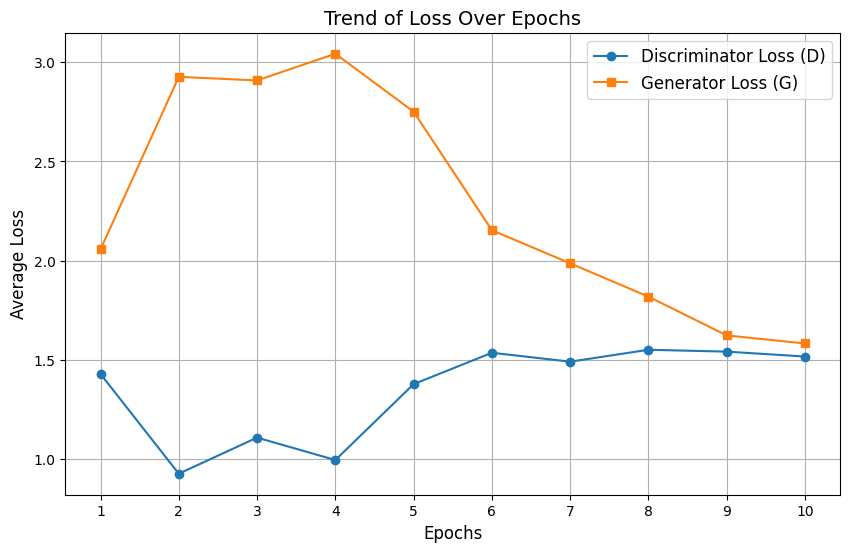

In [80]:
import matplotlib.pyplot as plt

# Loss values over epochs
epochs = list(range(1, 11))
avg_loss_d = [1.4301, 0.9278, 1.1096, 0.9967, 1.3788, 1.5367, 1.4919, 1.5518, 1.5424, 1.5177]
avg_loss_g = [2.0569, 2.9258, 2.9076, 3.0421, 2.7501, 2.1536, 1.9868, 1.8191, 1.6240, 1.5835]

# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, avg_loss_d, label="Discriminator Loss (D)", marker='o')
plt.plot(epochs, avg_loss_g, label="Generator Loss (G)", marker='s')
plt.title("Trend of Loss Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Average Loss", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(epochs)
plt.show()


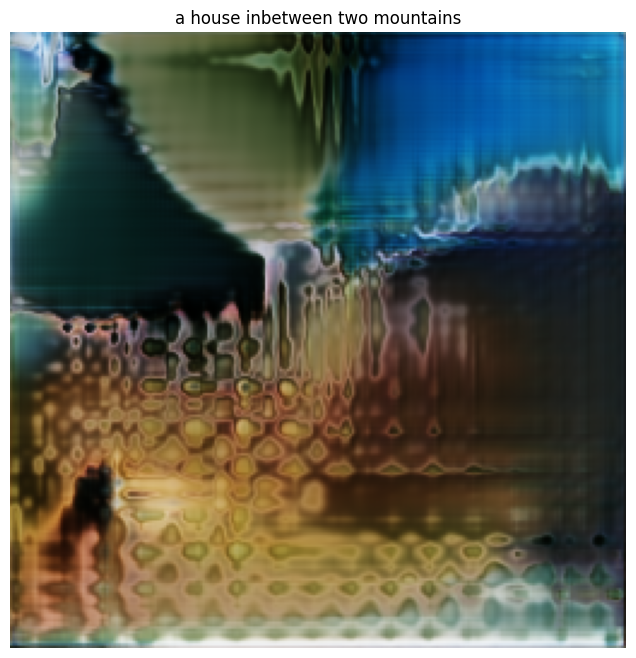

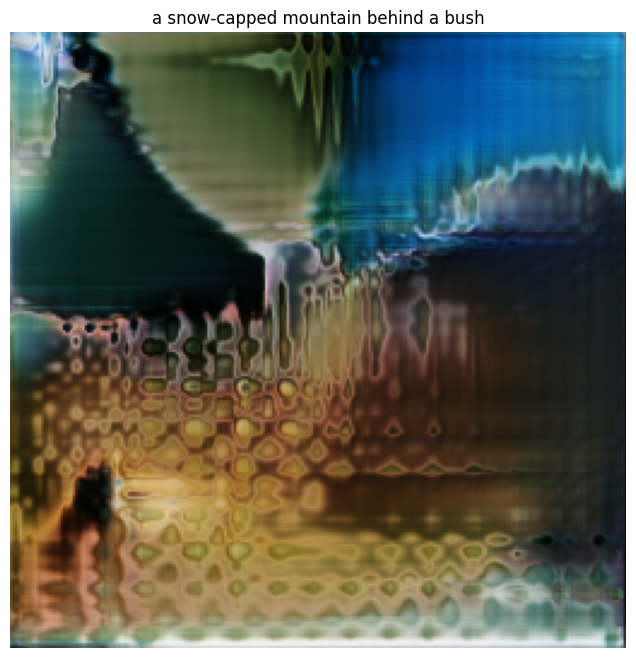

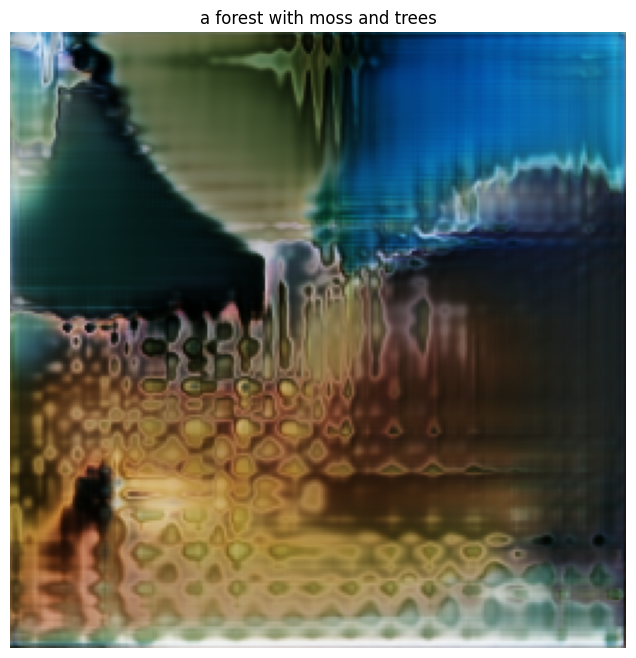

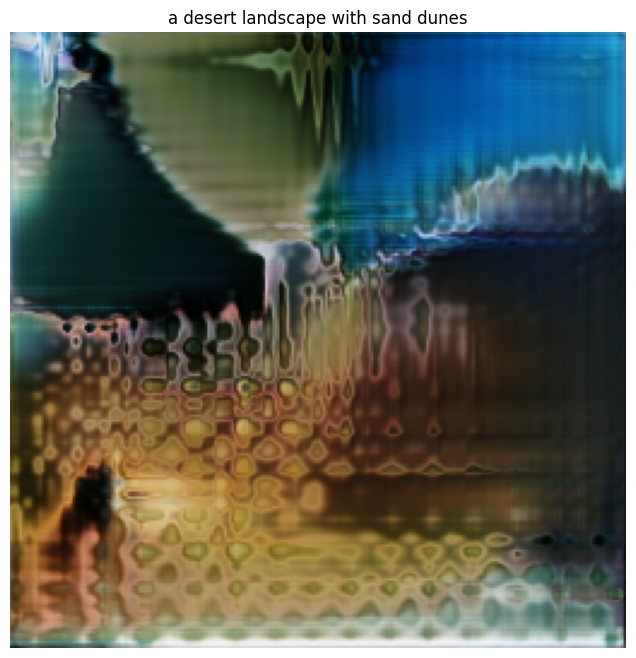

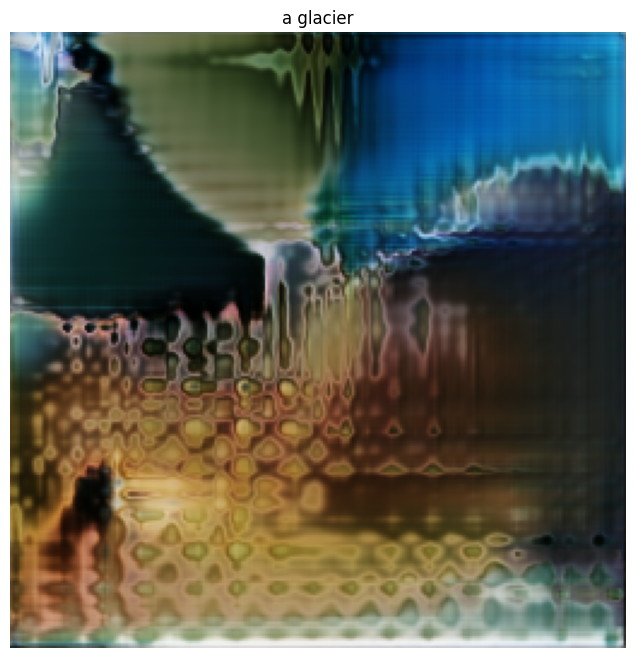

In [12]:
def generate_stylegan_images(generator, text_encoder, tokenizer, text_list, device, noise_dim=100):
    """
    Generates and displays images based on a list of textual descriptions.

    Args:
        generator (nn.Module): Trained StyleGAN generator.
        text_encoder (nn.Module): Trained text encoder.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for text.
        text_list (list): List of text descriptions.
        device (torch.device): Device to perform computations on.
        noise_dim (int): Dimension of the noise vector.
    """
    generator.eval()
    text_encoder.eval()

    with torch.no_grad():
        for text in text_list:
            # Tokenize text
            encoding = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt',
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            # Get text embedding
            text_embedding = text_encoder(input_ids)  # (1, embed_dim)

            # Generate noise
            noise = torch.randn(1, noise_dim).to(device)

            # Generate image
            fake_image = generator(noise, text_embedding)  # (1, 3, 256, 256)
            fake_image = fake_image.squeeze(0)
            fake_image = (fake_image * 0.5) + 0.5  # Denormalize to [0,1]
            fake_image = fake_image.cpu().permute(1, 2, 0).numpy()

            # Display image
            plt.figure(figsize=(8,8))
            plt.imshow(fake_image)
            plt.title(text)
            plt.axis('off')
            plt.show()

# Example usage
sample_texts = [
    "a house inbetween two mountains",
    "a snow-capped mountain behind a bush",
    "a forest with moss and trees",
    "a desert landscape with sand dunes",
    "a glacier"
]

generate_stylegan_images(generator, text_encoder, tokenizer, sample_texts, device)

In [10]:
 # Save models 
os.makedirs('models', exist_ok=True)
torch.save(generator.state_dict(), f'models/generator.pth')
torch.save(discriminator.state_dict(), f'models/discriminator.pth')
torch.save(text_encoder.state_dict(), f'models/text_encoder.pth')


In [ ]:
# Install pytorch-fid
!pip install pytorch-fid


****NOW WE ARE GOING TO TEST 64x64 WITH EVERYTHING ACCORDING TO THE RUBRICS****

In [17]:
import json
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import save_image


from pytorch_fid import fid_score

# Ensure reproducibility
torch.manual_seed(42)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'Number of GPUs available: {torch.cuda.device_count()}')

class LandscapeDataset(Dataset):
    def __init__(self, data, image_transform=None, tokenizer=None, max_length=128):
        """
        Args:
            data (dict): Dictionary with image paths as keys and captions as values.
            image_transform (callable, optional): Optional transform to be applied on an image.
            tokenizer (transformers.PreTrainedTokenizer, optional): Tokenizer for captions.
            max_length (int): Maximum length for tokenized captions.
        """
        self.image_paths = list(data.keys())
        self.captions = list(data.values())
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        caption = self.captions[idx]
        
        # Handle relative paths if necessary
        if not os.path.isabs(img_path):
            img_path = os.path.join('/kaggle/input/combined-landscape-captions/', img_path)
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image in case of error
            image = Image.new('RGB', (64, 64), (0, 0, 0))
        
        if self.image_transform:
            image = self.image_transform(image)
        
        # Tokenize caption
        if self.tokenizer:
            encoding = self.tokenizer.encode_plus(
                caption,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt',
            )
            input_ids = encoding['input_ids'].squeeze()  # Shape: (max_length)
            attention_mask = encoding['attention_mask'].squeeze()  # Shape: (max_length)
        else:
            input_ids = torch.tensor(0)
            attention_mask = torch.tensor(0)

        return {
            'image': image,                      # Tensor: (3, 64, 64)
            'input_ids': input_ids,              # Tensor: (max_length)
            'attention_mask': attention_mask,    # Tensor: (max_length)
            'caption': caption
        }
        
# Image transformations for 64x64 images
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Updated size to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Normalizing between -1 and 1
                         std=[0.5, 0.5, 0.5]),
])


Using device: cuda
Number of GPUs available: 2


In [27]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Path to the JSON file
json_path = '/kaggle/input/combined-landscape-captions/combined_landscape_captions.json'

# Load JSON data
with open(json_path, 'r') as f:
    data = json.load(f)

# Verify the number of samples
print(f"Total samples: {len(data)}")

# Optional: Inspect a sample
sample_image_path, sample_caption = next(iter(data.items()))
print(f"Sample Image Path: {sample_image_path}")
print(f"Sample Caption: {sample_caption}")

# Create the dataset
dataset = LandscapeDataset(data, image_transform=image_transform, tokenizer=tokenizer)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 8  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


Total samples: 14319
Sample Image Path: /kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Training Data/Coast/Coast-Train (1868).jpeg
Sample Caption: palm trees and the skyline of miami at sunset


In [28]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, embed_dim, batch_first=True)
    
    def forward(self, input_ids):
        """
        Args:
            input_ids (Tensor): Tensor of token IDs with shape (batch_size, max_length)
        Returns:
            Tensor: Text embeddings with shape (batch_size, embed_dim)
        """
        x = self.embedding(input_ids)  # (batch_size, max_length, embed_dim)
        _, (hidden, _) = self.lstm(x)  # hidden: (1, batch_size, embed_dim)
        return hidden.squeeze(0)  # (batch_size, embed_dim)
        
class MappingNetwork(nn.Module):
    def __init__(self, noise_dim, embed_dim, style_dim=512, num_layers=8):
        super(MappingNetwork, self).__init__()
        layers = []
        input_dim = noise_dim + embed_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, style_dim))
            layers.append(nn.ReLU(inplace=True))
            input_dim = style_dim
        self.mapping = nn.Sequential(*layers)
    
    def forward(self, noise, text_embedding):
        """
        Args:
            noise (Tensor): Noise vector with shape (batch_size, noise_dim)
            text_embedding (Tensor): Text embedding with shape (batch_size, embed_dim)
        Returns:
            Tensor: Style vector with shape (batch_size, style_dim)
        """
        x = torch.cat([noise, text_embedding], dim=1)  # (batch_size, noise_dim + embed_dim)
        styles = self.mapping(x)  # (batch_size, style_dim)
        return styles
        
class StyleGANGenerator(nn.Module):
    def __init__(self, noise_dim, embed_dim, style_dim=512, channels=3):
        super(StyleGANGenerator, self).__init__()
        self.style_dim = style_dim
        self.channels = channels
        self.mapping_network = MappingNetwork(noise_dim, embed_dim, style_dim)
        
        # Initial block
        self.initial_block = nn.Sequential(
            nn.ConvTranspose2d(style_dim, style_dim, 4, 1, 0),  # 1x1 -> 4x4
            nn.BatchNorm2d(style_dim),
            nn.ReLU(True)
        )
        
        # Define convolutional blocks for each resolution
        self.conv_blocks = nn.ModuleList()
        self.to_rgb_layers = nn.ModuleList()
        resolutions = [8, 16, 32, 64]  # Updated resolutions for 64x64 images
        
        for res in resolutions:
            self.conv_blocks.append(
                nn.Sequential(
                    nn.Conv2d(style_dim, style_dim, 3, 1, 1),
                    nn.BatchNorm2d(style_dim),
                    nn.ReLU(True),
                    nn.Conv2d(style_dim, style_dim, 3, 1, 1),
                    nn.BatchNorm2d(style_dim),
                    nn.ReLU(True),
                )
            )
            self.to_rgb_layers.append(
                nn.Conv2d(style_dim, self.channels, 1)
            )
        
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.final_activation = nn.Tanh()
    
    def forward(self, noise, text_embedding):
        """
        Args:
            noise (Tensor): Noise vector with shape (batch_size, noise_dim)
            text_embedding (Tensor): Text embedding with shape (batch_size, embed_dim)
        Returns:
            Tensor: Generated images with shape (batch_size, 3, 64, 64)
        """
        styles = self.mapping_network(noise, text_embedding)  # (batch_size, style_dim)
        x = styles.unsqueeze(2).unsqueeze(3)  # (batch_size, style_dim, 1, 1)
        x = self.initial_block(x)  # (batch_size, style_dim, 4, 4)
        
        for idx, block in enumerate(self.conv_blocks):
            x = self.upsample(x)  # Upsample to next resolution
            x = block(x)  # Apply convolutional block
            rgb = self.to_rgb_layers[idx](x)  # Convert to RGB
            if idx == len(self.conv_blocks) - 1:
                img = self.final_activation(rgb)  # Apply Tanh on final layer
        
        return img  # (batch_size, 3, 64, 64)
        
class StyleGANDiscriminator(nn.Module):
    def __init__(self, embed_dim, feature_maps=64, channels=3):
        super(StyleGANDiscriminator, self).__init__()
        self.feature_maps = feature_maps
        
        # Define convolutional blocks for each resolution
        resolutions = [64, 32, 16, 8, 4]
        self.from_rgb = nn.ModuleList()
        self.blocks = nn.ModuleList()
        
        for res in resolutions:
            self.from_rgb.append(
                nn.Sequential(
                    nn.Conv2d(channels, feature_maps, 1),
                )
            )
            self.blocks.append(
                nn.Sequential(
                    nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1),
                    nn.BatchNorm2d(feature_maps * 2),
                    nn.LeakyReLU(0.2, inplace=True),
                    
                    nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1),
                    nn.BatchNorm2d(feature_maps * 4),
                    nn.LeakyReLU(0.2, inplace=True),
                    
                    nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1),
                    nn.BatchNorm2d(feature_maps * 8),
                    nn.LeakyReLU(0.2, inplace=True),
                )
            )
        
        self.text_projection = nn.Linear(embed_dim, feature_maps * 8 * 2 * 2)
        self.final_conv = nn.Conv2d(feature_maps * 8, 1, kernel_size=2)
        # Removed Sigmoid activation to use BCEWithLogitsLoss
    
    def forward(self, img, text_embedding):
        batch_size = img.size(0)
        resolutions = [64, 32, 16, 8, 4]
        x = None
        
        # Identify the resolution of the input image and select the corresponding block
        for idx, res in enumerate(resolutions):
            if img.size(2) == res:
                x = self.from_rgb[idx](img)
                break
        if x is None:
            raise ValueError("Input image resolution not supported.")
        
        x = self.blocks[idx](x)
        
        # Project text embedding
        x_text = self.text_projection(text_embedding)
        x_text = x_text.view(batch_size, self.feature_maps * 8, 2, 2)
        
        # Ensure x and x_text have the same spatial dimensions
        if x.size() != x_text.size():
            x = nn.functional.interpolate(x, size=x_text.shape[2:], mode='nearest')
        
        # Element-wise addition
        x = x + x_text
        
        out = self.final_conv(x).view(-1)
        return out  # (batch_size)


In [29]:
# Initialize models
vocab_size = tokenizer.vocab_size
embedding_dim = 256
style_dim = 512  # Typically higher for StyleGAN
noise_dim = 100

text_encoder = TextEncoder(vocab_size, embedding_dim)
generator = StyleGANGenerator(noise_dim=noise_dim, embed_dim=embedding_dim, style_dim=style_dim)
discriminator = StyleGANDiscriminator(embed_dim=embedding_dim, feature_maps=64)

# Move models to GPU if available
text_encoder = text_encoder.to(device)
generator = generator.to(device)
discriminator = discriminator.to(device)

# Utilize multiple GPUs if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for Data Parallelism.")
    text_encoder = nn.DataParallel(text_encoder, device_ids=list(range(torch.cuda.device_count())))
    generator = nn.DataParallel(generator, device_ids=list(range(torch.cuda.device_count())))
    discriminator = nn.DataParallel(discriminator, device_ids=list(range(torch.cuda.device_count())))

# Loss function
criterion = nn.BCEWithLogitsLoss()  # Updated to BCEWithLogitsLoss

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_TE = optim.Adam(text_encoder.parameters(), lr=lr, betas=(beta1, 0.999))

# Mixed Precision Scaler
scaler = torch.cuda.amp.GradScaler()


Using 2 GPUs for Data Parallelism.


/tmp/ipykernel_23/964667516.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [30]:
def train_style_gan(train_loader, text_encoder, generator, discriminator, 
                   optimizer_G, optimizer_D, optimizer_TE, criterion, scaler, device, epochs=10):
    history = {
        'd_loss': [],
        'g_loss': []
    }
    
    for epoch in range(epochs):
        generator.train()
        discriminator.train()
        text_encoder.train()

        total_d_loss = 0
        total_g_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = batch['image'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)

            batch_size = images.size(0)

            # Generate labels
            real_labels = torch.ones(batch_size, device=device)
            fake_labels = torch.zeros(batch_size, device=device)

            # =====================
            # Train Discriminator
            # =====================
            optimizer_D.zero_grad()

            with torch.amp.autocast(device_type='cuda'):
                # Real images
                text_embeddings_real = text_encoder(input_ids)  # (batch_size, embed_dim)
                real_outputs = discriminator(images, text_embeddings_real)
                d_loss_real = criterion(real_outputs, real_labels)

                # Fake images
                noise = torch.randn(batch_size, noise_dim, device=device)
                fake_images = generator(noise, text_embeddings_real.detach())
                fake_outputs = discriminator(fake_images.detach(), text_embeddings_real.detach())
                d_loss_fake = criterion(fake_outputs, fake_labels)

                # Total discriminator loss
                d_loss = d_loss_real + d_loss_fake

            scaler.scale(d_loss).backward()
            scaler.step(optimizer_D)
            scaler.update()

            # =====================
            # Train Generator
            # =====================
            optimizer_G.zero_grad()
            optimizer_TE.zero_grad()

            with torch.amp.autocast(device_type='cuda'):
                noise = torch.randn(batch_size, noise_dim, device=device)
                # Recompute text embeddings for generator training
                text_embeddings_gen = text_encoder(input_ids)  # (batch_size, embed_dim)
                fake_images = generator(noise, text_embeddings_gen)
                g_outputs = discriminator(fake_images, text_embeddings_gen)
                g_loss = criterion(g_outputs, real_labels)  # Want discriminator to believe these are real

            scaler.scale(g_loss).backward()
            scaler.step(optimizer_G)
            scaler.update()

            # Accumulate losses
            total_d_loss += d_loss.item()
            total_g_loss += g_loss.item()

        # Calculate average losses
        avg_d_loss = total_d_loss / len(train_loader)
        avg_g_loss = total_g_loss / len(train_loader)
        history['d_loss'].append(avg_d_loss)
        history['g_loss'].append(avg_g_loss)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss D: {avg_d_loss:.4f}, Avg Loss G: {avg_g_loss:.4f}")
        
        # Clear cache to free memory
        torch.cuda.empty_cache()
    
    return history


In [31]:
# Start training
epochs = 20  # Adjust based on your requirements and computational resources
history = train_style_gan(train_loader, text_encoder, generator, discriminator, 
                          optimizer_G, optimizer_D, optimizer_TE, criterion, scaler, device, epochs=epochs)
# Create a directory to save models
os.makedirs('models', exist_ok=True)

# Save the models
torch.save(generator.state_dict(), 'models/generator.pth')
torch.save(discriminator.state_dict(), 'models/discriminator.pth')
torch.save(text_encoder.state_dict(), 'models/text_encoder.pth')


Epoch 1/20: 100%|██████████| 1432/1432 [04:49<00:00,  4.95it/s]


Epoch [1/20], Avg Loss D: 1.4834, Avg Loss G: 0.9665


Epoch 2/20: 100%|██████████| 1432/1432 [04:48<00:00,  4.96it/s]


Epoch [2/20], Avg Loss D: 1.4156, Avg Loss G: 0.7806


Epoch 3/20: 100%|██████████| 1432/1432 [04:49<00:00,  4.95it/s]


Epoch [3/20], Avg Loss D: 1.4060, Avg Loss G: 0.7958


Epoch 4/20: 100%|██████████| 1432/1432 [04:49<00:00,  4.95it/s]


Epoch [4/20], Avg Loss D: 1.4036, Avg Loss G: 0.7672


Epoch 5/20: 100%|██████████| 1432/1432 [04:49<00:00,  4.94it/s]


Epoch [5/20], Avg Loss D: 1.3987, Avg Loss G: 0.7241


Epoch 6/20: 100%|██████████| 1432/1432 [04:49<00:00,  4.94it/s]


Epoch [6/20], Avg Loss D: 1.3930, Avg Loss G: 0.7148


Epoch 7/20: 100%|██████████| 1432/1432 [04:49<00:00,  4.95it/s]


Epoch [7/20], Avg Loss D: 1.3902, Avg Loss G: 0.7002


Epoch 8/20: 100%|██████████| 1432/1432 [04:49<00:00,  4.95it/s]


Epoch [8/20], Avg Loss D: 1.3875, Avg Loss G: 0.6947


Epoch 9/20: 100%|██████████| 1432/1432 [04:48<00:00,  4.97it/s]


Epoch [9/20], Avg Loss D: 1.3873, Avg Loss G: 0.6958


Epoch 10/20: 100%|██████████| 1432/1432 [04:47<00:00,  4.98it/s]


Epoch [10/20], Avg Loss D: 1.3870, Avg Loss G: 0.6945


Epoch 11/20: 100%|██████████| 1432/1432 [04:47<00:00,  4.98it/s]


Epoch [11/20], Avg Loss D: 1.3867, Avg Loss G: 0.6940


Epoch 12/20: 100%|██████████| 1432/1432 [04:48<00:00,  4.97it/s]


Epoch [12/20], Avg Loss D: 1.3866, Avg Loss G: 0.6937


Epoch 13/20: 100%|██████████| 1432/1432 [04:47<00:00,  4.99it/s]


Epoch [13/20], Avg Loss D: 1.3865, Avg Loss G: 0.6935


Epoch 14/20: 100%|██████████| 1432/1432 [04:47<00:00,  4.98it/s]


Epoch [14/20], Avg Loss D: 1.3864, Avg Loss G: 0.6935


Epoch 15/20: 100%|██████████| 1432/1432 [04:47<00:00,  4.98it/s]


Epoch [15/20], Avg Loss D: 1.3864, Avg Loss G: 0.6934


Epoch 16/20: 100%|██████████| 1432/1432 [04:47<00:00,  4.99it/s]


Epoch [16/20], Avg Loss D: 1.3864, Avg Loss G: 0.6935


Epoch 17/20: 100%|██████████| 1432/1432 [04:47<00:00,  4.98it/s]


Epoch [17/20], Avg Loss D: 1.3863, Avg Loss G: 0.6932


Epoch 18/20: 100%|██████████| 1432/1432 [04:47<00:00,  4.99it/s]


Epoch [18/20], Avg Loss D: 1.3864, Avg Loss G: 0.6933


Epoch 19/20: 100%|██████████| 1432/1432 [04:47<00:00,  4.98it/s]


Epoch [19/20], Avg Loss D: 1.3863, Avg Loss G: 0.6932


Epoch 20/20: 100%|██████████| 1432/1432 [04:50<00:00,  4.93it/s]


Epoch [20/20], Avg Loss D: 1.3863, Avg Loss G: 0.6933


In [43]:
# Load trained models (ensure models are loaded if restarting the notebook)
generator.load_state_dict(torch.load('models/generator.pth'))
discriminator.load_state_dict(torch.load('models/discriminator.pth'))
text_encoder.load_state_dict(torch.load('models/text_encoder.pth'))


/tmp/ipykernel_23/1745894273.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('models/generator.pth'))
/tmp/ipykernel_23/1745894273.p

<All keys matched successfully>

In [79]:
import os
import torch
from PIL import Image
from torchvision.utils import save_image
from pytorch_fid import fid_score
import matplotlib.pyplot as plt

# Directories for saving images
real_images_dir = '/kaggle/working/real_images'
generated_images_dir = '/kaggle/working/generated_images'

os.makedirs(real_images_dir, exist_ok=True)
os.makedirs(generated_images_dir, exist_ok=True)

def save_real_and_fake_images(val_loader, generator, text_encoder, tokenizer, device, noise_dim=100):
    """
    Save real images and generate fake images using captions from the validation dataset.
    
    Args:
        val_loader (DataLoader): Validation DataLoader.
        generator (nn.Module): Trained StyleGAN generator model.
        text_encoder (nn.Module): Trained text encoder model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for captions.
        device (str): Device to perform computations on ('cuda' or 'cpu').
        noise_dim (int): Dimension of the noise vector for generating fake images.
    """
    generator.eval()
    text_encoder.eval()
    
    for i, batch in enumerate(val_loader):
        real_images = batch['image'].to(device)
        captions = batch['caption']
        input_ids = batch['input_ids'].to(device)
        
        # Save real images
        for j in range(real_images.size(0)):
            real_image_path = os.path.join(real_images_dir, f'real_{i * val_loader.batch_size + j}.png')
            save_image(real_images[j], real_image_path)
        
        # Generate fake images
        with torch.no_grad():
            text_embeddings = text_encoder(input_ids)
            noise = torch.randn(real_images.size(0), noise_dim, device=device)
            fake_images = generator(noise, text_embeddings)
        
        # Save fake images
        for j in range(fake_images.size(0)):
            fake_image_path = os.path.join(generated_images_dir, f'fake_{i * val_loader.batch_size + j}.png')
            save_image(fake_images[j], fake_image_path)
        
        # Print progress
        

# Generate real and fake images from validation dataset
save_real_and_fake_images(val_loader, generator, text_encoder, tokenizer, device)

print('Real and fake image generation complete.')

# Convert all images to RGB format
def convert_images_to_rgb(directory):
    """
    Converts all images in the specified directory to RGB format.
    
    Args:
        directory (str): Path to the directory containing images.
    """
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        try:
            with Image.open(img_path) as img:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                    img.save(img_path)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

convert_images_to_rgb(real_images_dir)
convert_images_to_rgb(generated_images_dir)

print('Image color conversion complete.')

# Resize images to 299x299
def resize_images(directory, size=(299, 299)):
    """
    Resizes all images in the specified directory to the given size using Resampling.LANCZOS.
    
    Args:
        directory (str): Path to the directory containing images.
        size (tuple): Desired image size as (width, height).
    """
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        try:
            with Image.open(img_path) as img:
                img = img.resize(size, resample=Image.Resampling.LANCZOS)
                img.save(img_path)
        except Exception as e:
            print(f"Error resizing image {img_path}: {e}")

resize_images(real_images_dir)
resize_images(generated_images_dir)

print('Image resizing complete.')

# Validate processed images
def validate_images(directory):
    """
    Validates all images in the specified directory to ensure they are not corrupted.
    
    Args:
        directory (str): Path to the directory containing images.
    """
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        try:
            with Image.open(img_path) as img:
                img.verify()  # Verify the image
        except Exception as e:
            print(f"Image {img_path} is corrupted or invalid: {e}")

validate_images(real_images_dir)
validate_images(generated_images_dir)

print('Image validation complete.')

# Compute FID score
def compute_fid(real_dir, fake_dir, device='cuda', batch_size=50, dims=2048):
    """
    Computes the Frechet Inception Distance between real and fake image directories.
    
    Args:
        real_dir (str): Directory containing real images.
        fake_dir (str): Directory containing fake/generated images.
        device (str): Device to perform computations on ('cuda' or 'cpu').
        batch_size (int): Batch size for FID computation.
        dims (int): Dimensionality of features extracted by Inception network.
    
    Returns:
        float: FID score.
    """
    fid_value = fid_score.calculate_fid_given_paths(
        [real_dir, fake_dir],
        batch_size=batch_size,
        device=device,
        dims=dims
    )
    return fid_value

fid_score_value = compute_fid(real_images_dir, generated_images_dir, device=device)
print(f"FID Score: {fid_score_value}")


Real and fake image generation complete.
Image color conversion complete.
Image resizing complete.
Image validation complete.


100%|██████████| 58/58 [00:14<00:00,  3.96it/s]


FID Score: 100.55777083621774


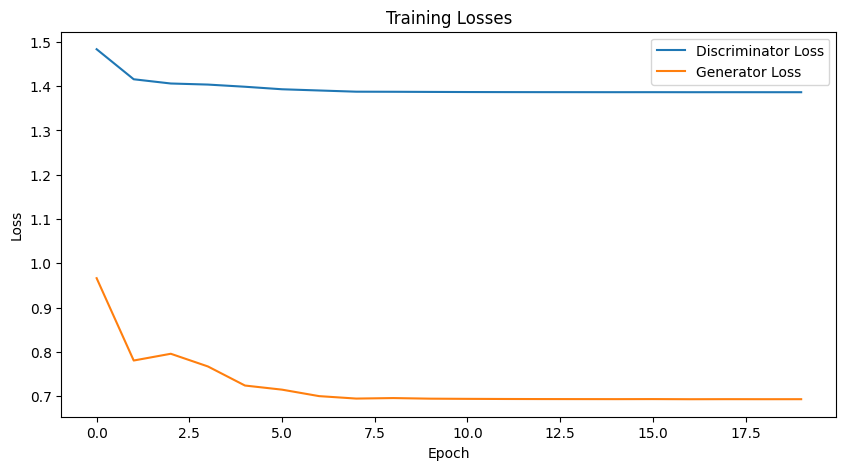

In [35]:
def plot_training_losses(history):
    """
    Plots the discriminator and generator losses over epochs.
    
    Args:
        history (dict): Dictionary containing 'd_loss' and 'g_loss' lists.
    """
    plt.figure(figsize=(10,5))
    plt.plot(history['d_loss'], label='Discriminator Loss')
    plt.plot(history['g_loss'], label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.show()
# Plot the training losses
plot_training_losses(history)


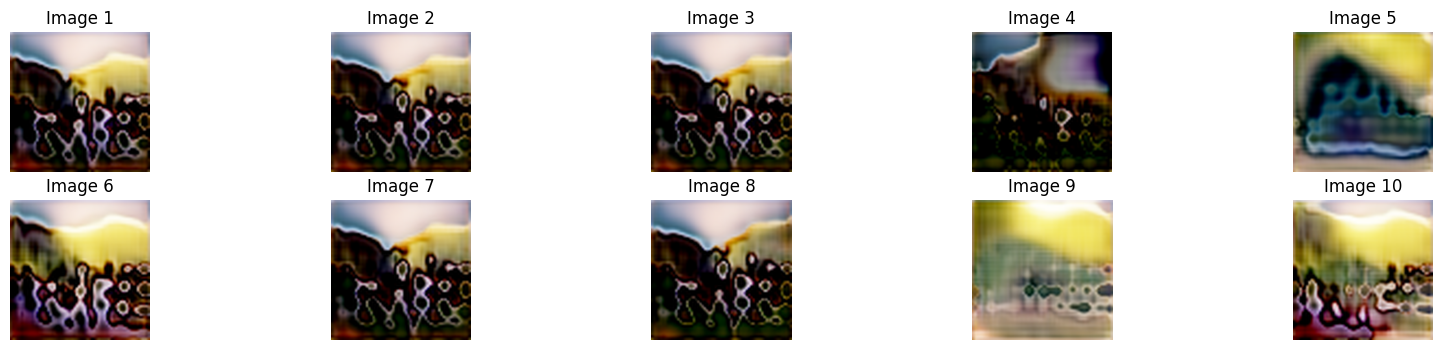

In [78]:
def display_generated_images(directory, num_images=10):
    """
    Displays a specified number of generated images from a directory.
    
    Args:
        directory (str): Directory containing generated images.
        num_images (int): Number of images to display.
    """
    import matplotlib.pyplot as plt
    from PIL import Image

    image_files = os.listdir(directory)[:num_images]
    plt.figure(figsize=(20, 4))
    for idx, img_name in enumerate(image_files):
        img_path = os.path.join(directory, img_name)
        img = Image.open(img_path)
        plt.subplot(2, num_images//2, idx+1)
        plt.imshow(img)
        plt.title(f"Image {idx+1}")
        plt.axis('off')
    plt.show()
# Display 10 generated images
display_generated_images('generated_images', num_images=10)


Image saved to generated_image.png


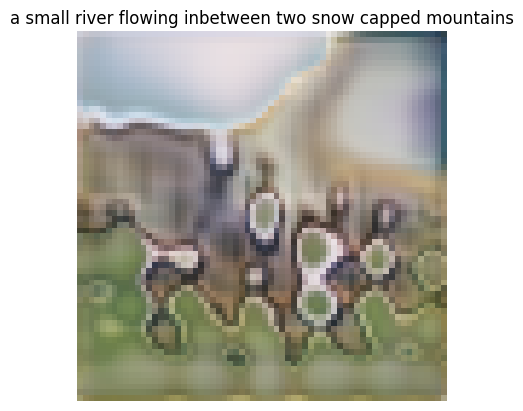

In [72]:
def generate_image_from_caption(caption, generator, text_encoder, tokenizer, noise_dim=100, device='cuda', save_path=None):
    """
    Generates an image based on a given caption using the trained generator and text encoder.

    Args:
        caption (str): The textual description for the image.
        generator (nn.Module): Trained StyleGAN generator model.
        text_encoder (nn.Module): Trained text encoder model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for the text input.
        noise_dim (int): Dimensionality of the noise vector.
        device (str): Device to perform computations on ('cuda' or 'cpu').
        save_path (str, optional): Path to save the generated image. If None, the image will not be saved.

    Returns:
        PIL.Image.Image: The generated image.
    """
    # Set models to evaluation mode
    generator.eval()
    text_encoder.eval()
    
    # Tokenize the caption
    encoding = tokenizer.encode_plus(
        caption,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get text embedding
    with torch.no_grad():
        text_embedding = text_encoder(input_ids)  # (1, embed_dim)
    
    # Generate noise vector
    noise = torch.randn(1, noise_dim, device=device)  # (1, noise_dim)
    
    # Generate image
    with torch.no_grad():
        fake_image = generator(noise, text_embedding)  # (1, 3, 64, 64)
    
    # Post-process the image
    fake_image = fake_image.squeeze(0)  # Remove batch dimension
    fake_image = (fake_image * 0.5) + 0.5  # Denormalize to [0, 1]
    fake_image = fake_image.cpu().permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    
    # Convert to PIL Image
    generated_image = Image.fromarray((fake_image * 255).astype('uint8'))
    
    # Save the image if a path is provided
    if save_path:
        generated_image.save(save_path)
        print(f"Image saved to {save_path}")
    
    return generated_image

# Example usage
caption = "a small river flowing inbetween two snow capped mountains"
generated_image = generate_image_from_caption(
    caption,
    generator,
    text_encoder,
    tokenizer,
    noise_dim=100,
    device=device,
    save_path='generated_image.png'
)

# Display the generated image
plt.imshow(generated_image)
plt.axis('off')
plt.title(caption)
plt.show()
